In [8]:
import os, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter

import pandas as pd
import seaborn as sns

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
dir0 = os.path.dirname(dir1)  # One level above dir1

plt.rcParams.update({
    'figure.dpi': 300,
    'axes.labelsize': 30.0,
    'axes.titlesize': 30.0,
    'axes.labelweight': 'normal',
    'axes.linewidth': 1.25,
    'legend.fontsize': 25,
    'legend.title_fontsize': 18.0,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'lines.linewidth': 2.0,
    'lines.markersize': 6.0,
    'grid.color': '.8',
    'grid.linestyle': '-',
    'grid.linewidth': 1.0,
})

if dir1 not in sys.path: sys.path.append(dir0)

from src.config import PPOConfig
from src.utils import ExperimentUtils

In [9]:
# helper methods
def csv_file_to_df(path):
    suite = ExperimentUtils(path=path)
    return suite.df

def get_strategy(pd_series):
    pattern = r"<EmbeddingStrategy\.(\w+):"
    return pd_series.str.extract(pattern)[0]

def get_agents_as_int(pd_series):
    return pd_series.str.extract(r'(\d+)').astype(int)

In [10]:
path = '/Users/simonhampp/Desktop/MA/swarm-rl/src/experiments_ma/6_scalability/saved_experiments/1_scale_all.csv'


df = csv_file_to_df(path)
df['agents'] = get_agents_as_int(df['name'])
df['strategy'] = get_strategy(df['config'])

kpi_df = pd.json_normalize(df['kpi']) # Normalize the dictionaries into separate columns
df = pd.concat([df.drop(columns=['kpi']), kpi_df], axis=1)

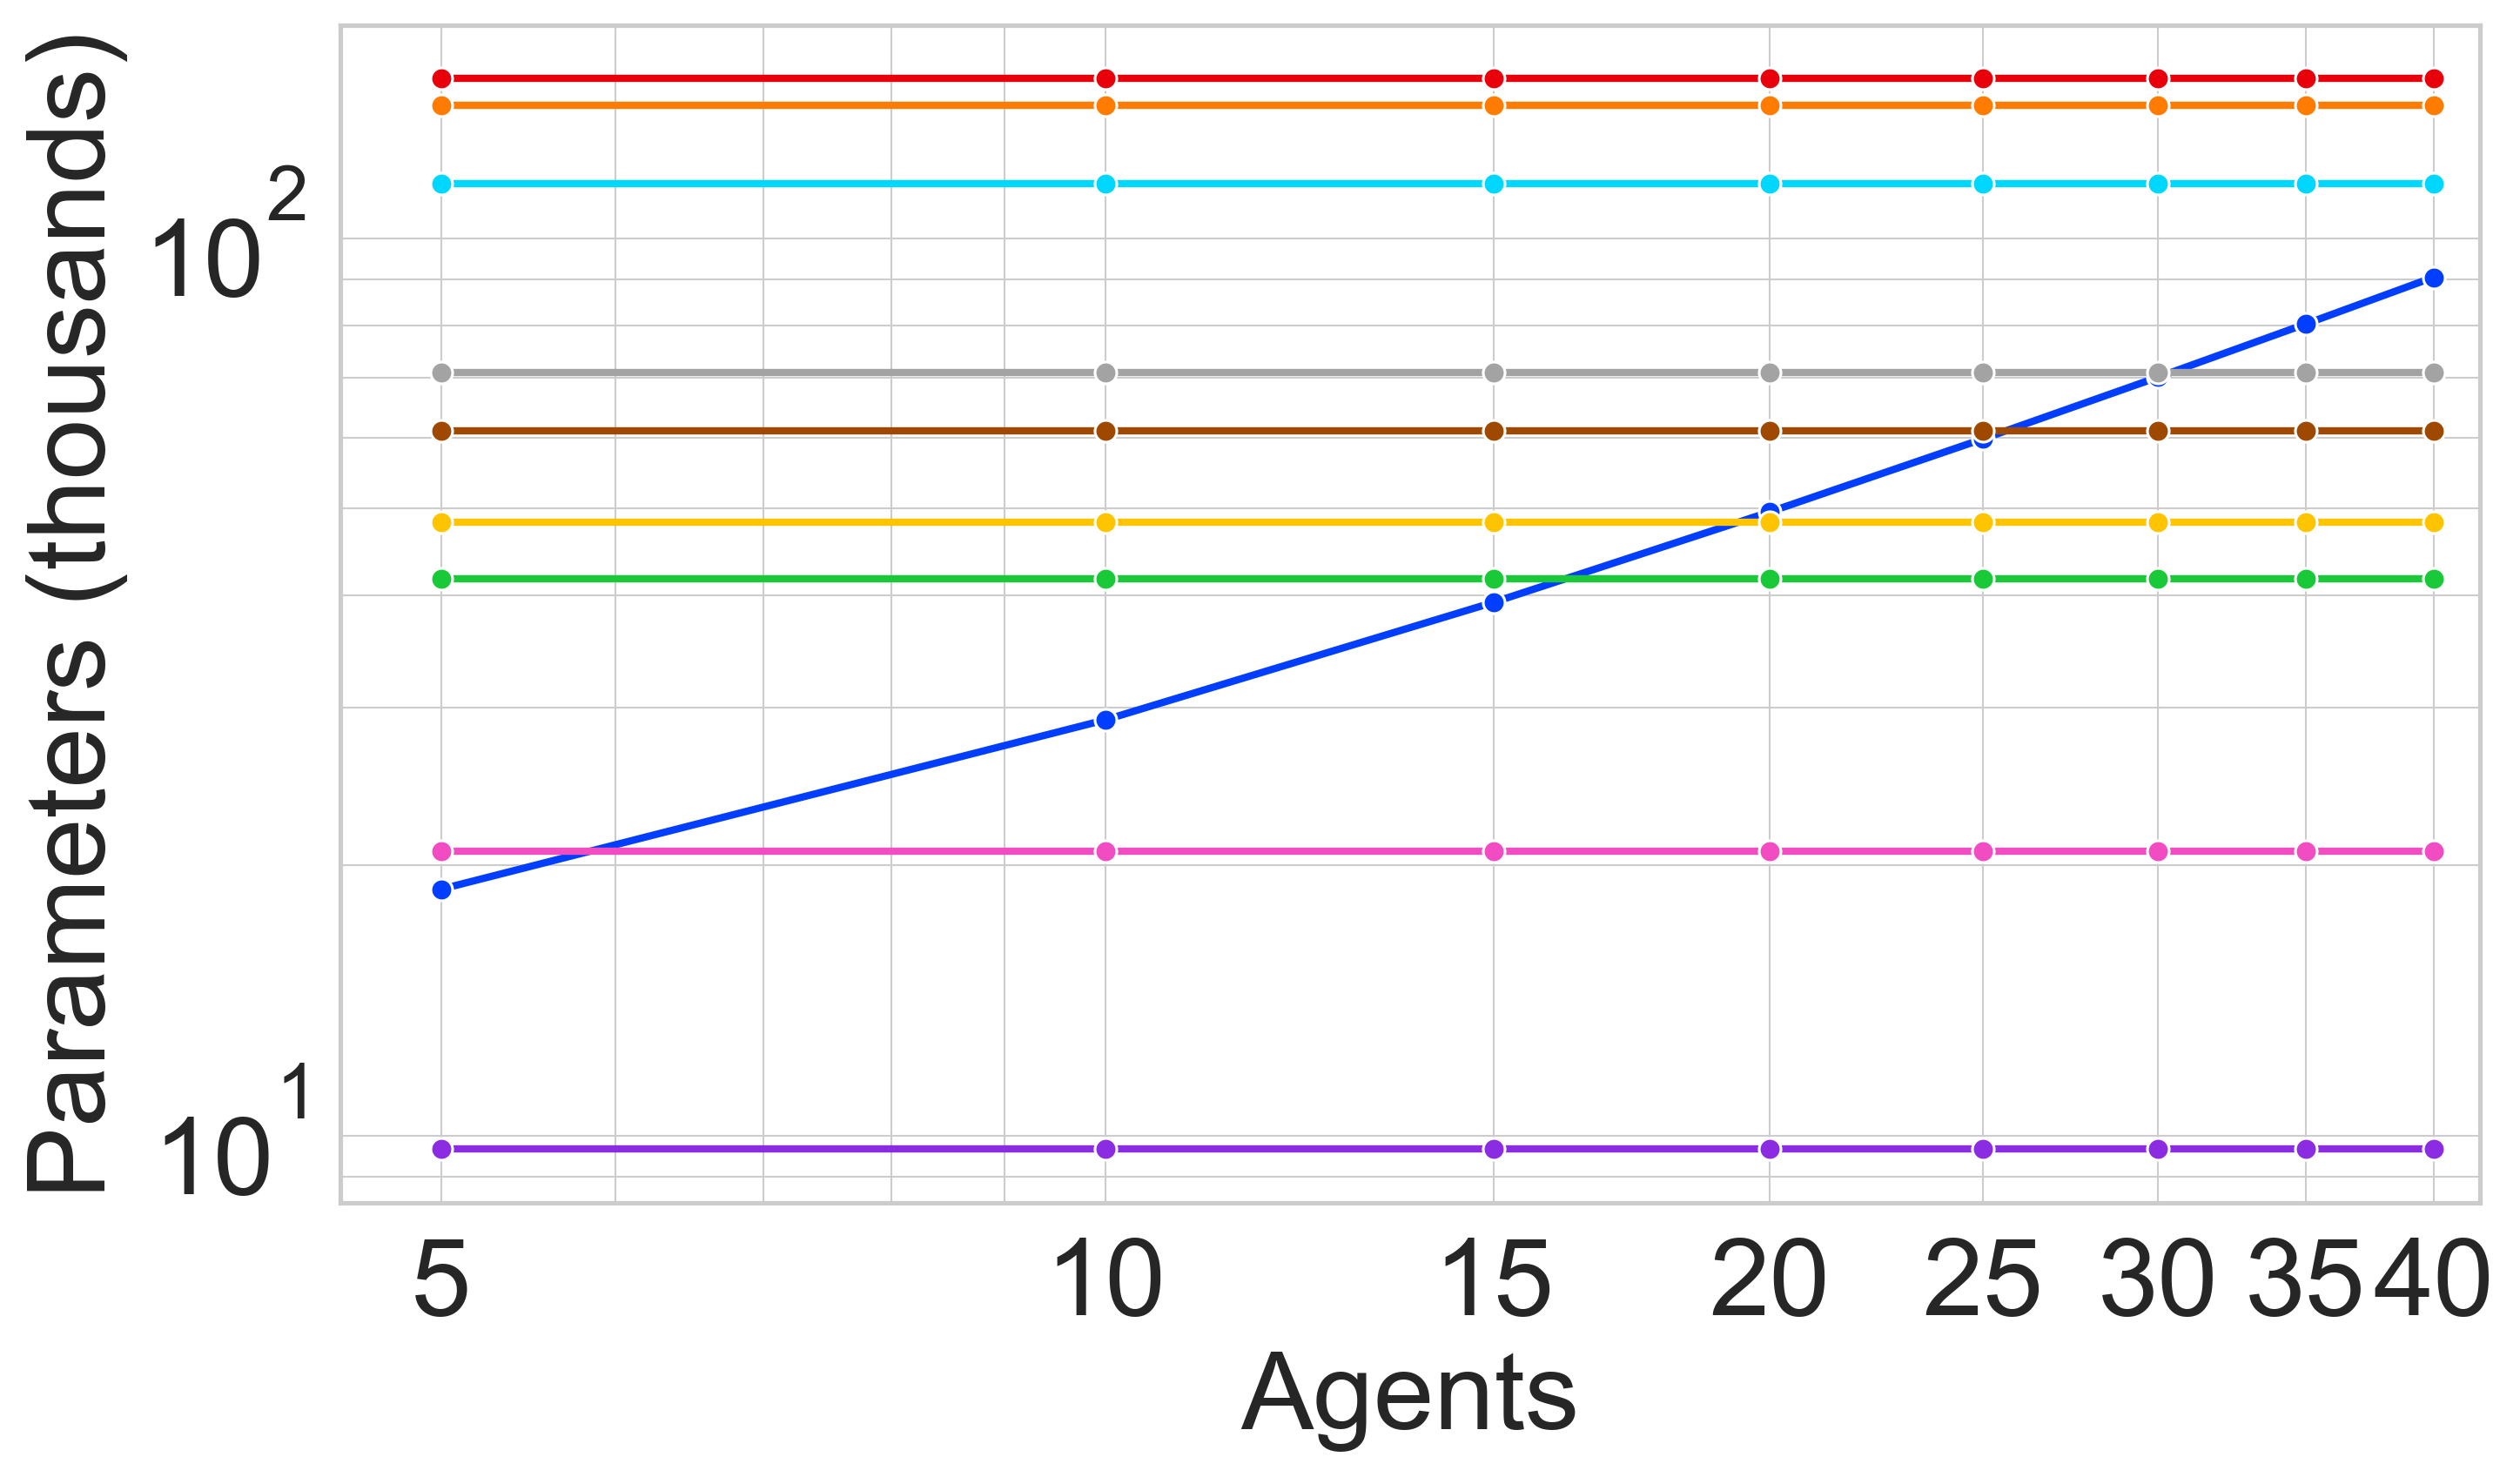

In [26]:
from matplotlib.ticker import FixedLocator, FixedFormatter, NullFormatter # Import these

plt.figure(figsize=(10, 6))

# Get unique strategies
strategies = df['strategy'].unique()

# ['name', 'config', 'agents', 'strategy', 'inference_time', 'inference_memory_usage', 'loss', 'mean_rewards', 'training_memory_usage', 'training_time', 'flops', 'parameters']

# Plot each strategy with the same marker and solid line
for strategy in strategies:
    # if strategy != 'SetTransformer' and strategy != 'Trans': # for memory usage
    # if strategy != 'SetTransformer' or strategy != 'ISABTransformer' or strategy != 'SABTransformer': # for memory usage
    subset = df[df['strategy'] == strategy]
    sns.lineplot(
        data=subset,
        x='agents',
        y='parameters',
        label=strategy,
        marker='o',          # Same marker for all
        linewidth=2,
        linestyle='-',         # Solid line
        estimator='mean',
    )

# Log scales
plt.xscale('log')
plt.yscale('log')

custom_tick_locations = [5, 10, 15, 20, 25, 30, 35, 40]
custom_tick_labels = [str(x) for x in custom_tick_locations]

ax = plt.gca()

ax.xaxis.set_major_locator(FixedLocator(custom_tick_locations))
ax.xaxis.set_major_formatter(FixedFormatter(custom_tick_labels))
ax.xaxis.set_minor_formatter(NullFormatter())

plt.xlim(4.5, 42)

# Parameters (thousands), Memory Usage (MB), Inference Time (s), FLOPs (millions), Training Time (s)

plt.xlabel('Agents')
plt.ylabel('Parameters (thousands)')
plt.grid(True, which='both', linewidth=0.5) # Keep grid for both major/minor for context
plt.tight_layout()
plt.gca().get_legend().remove()
plt.show()


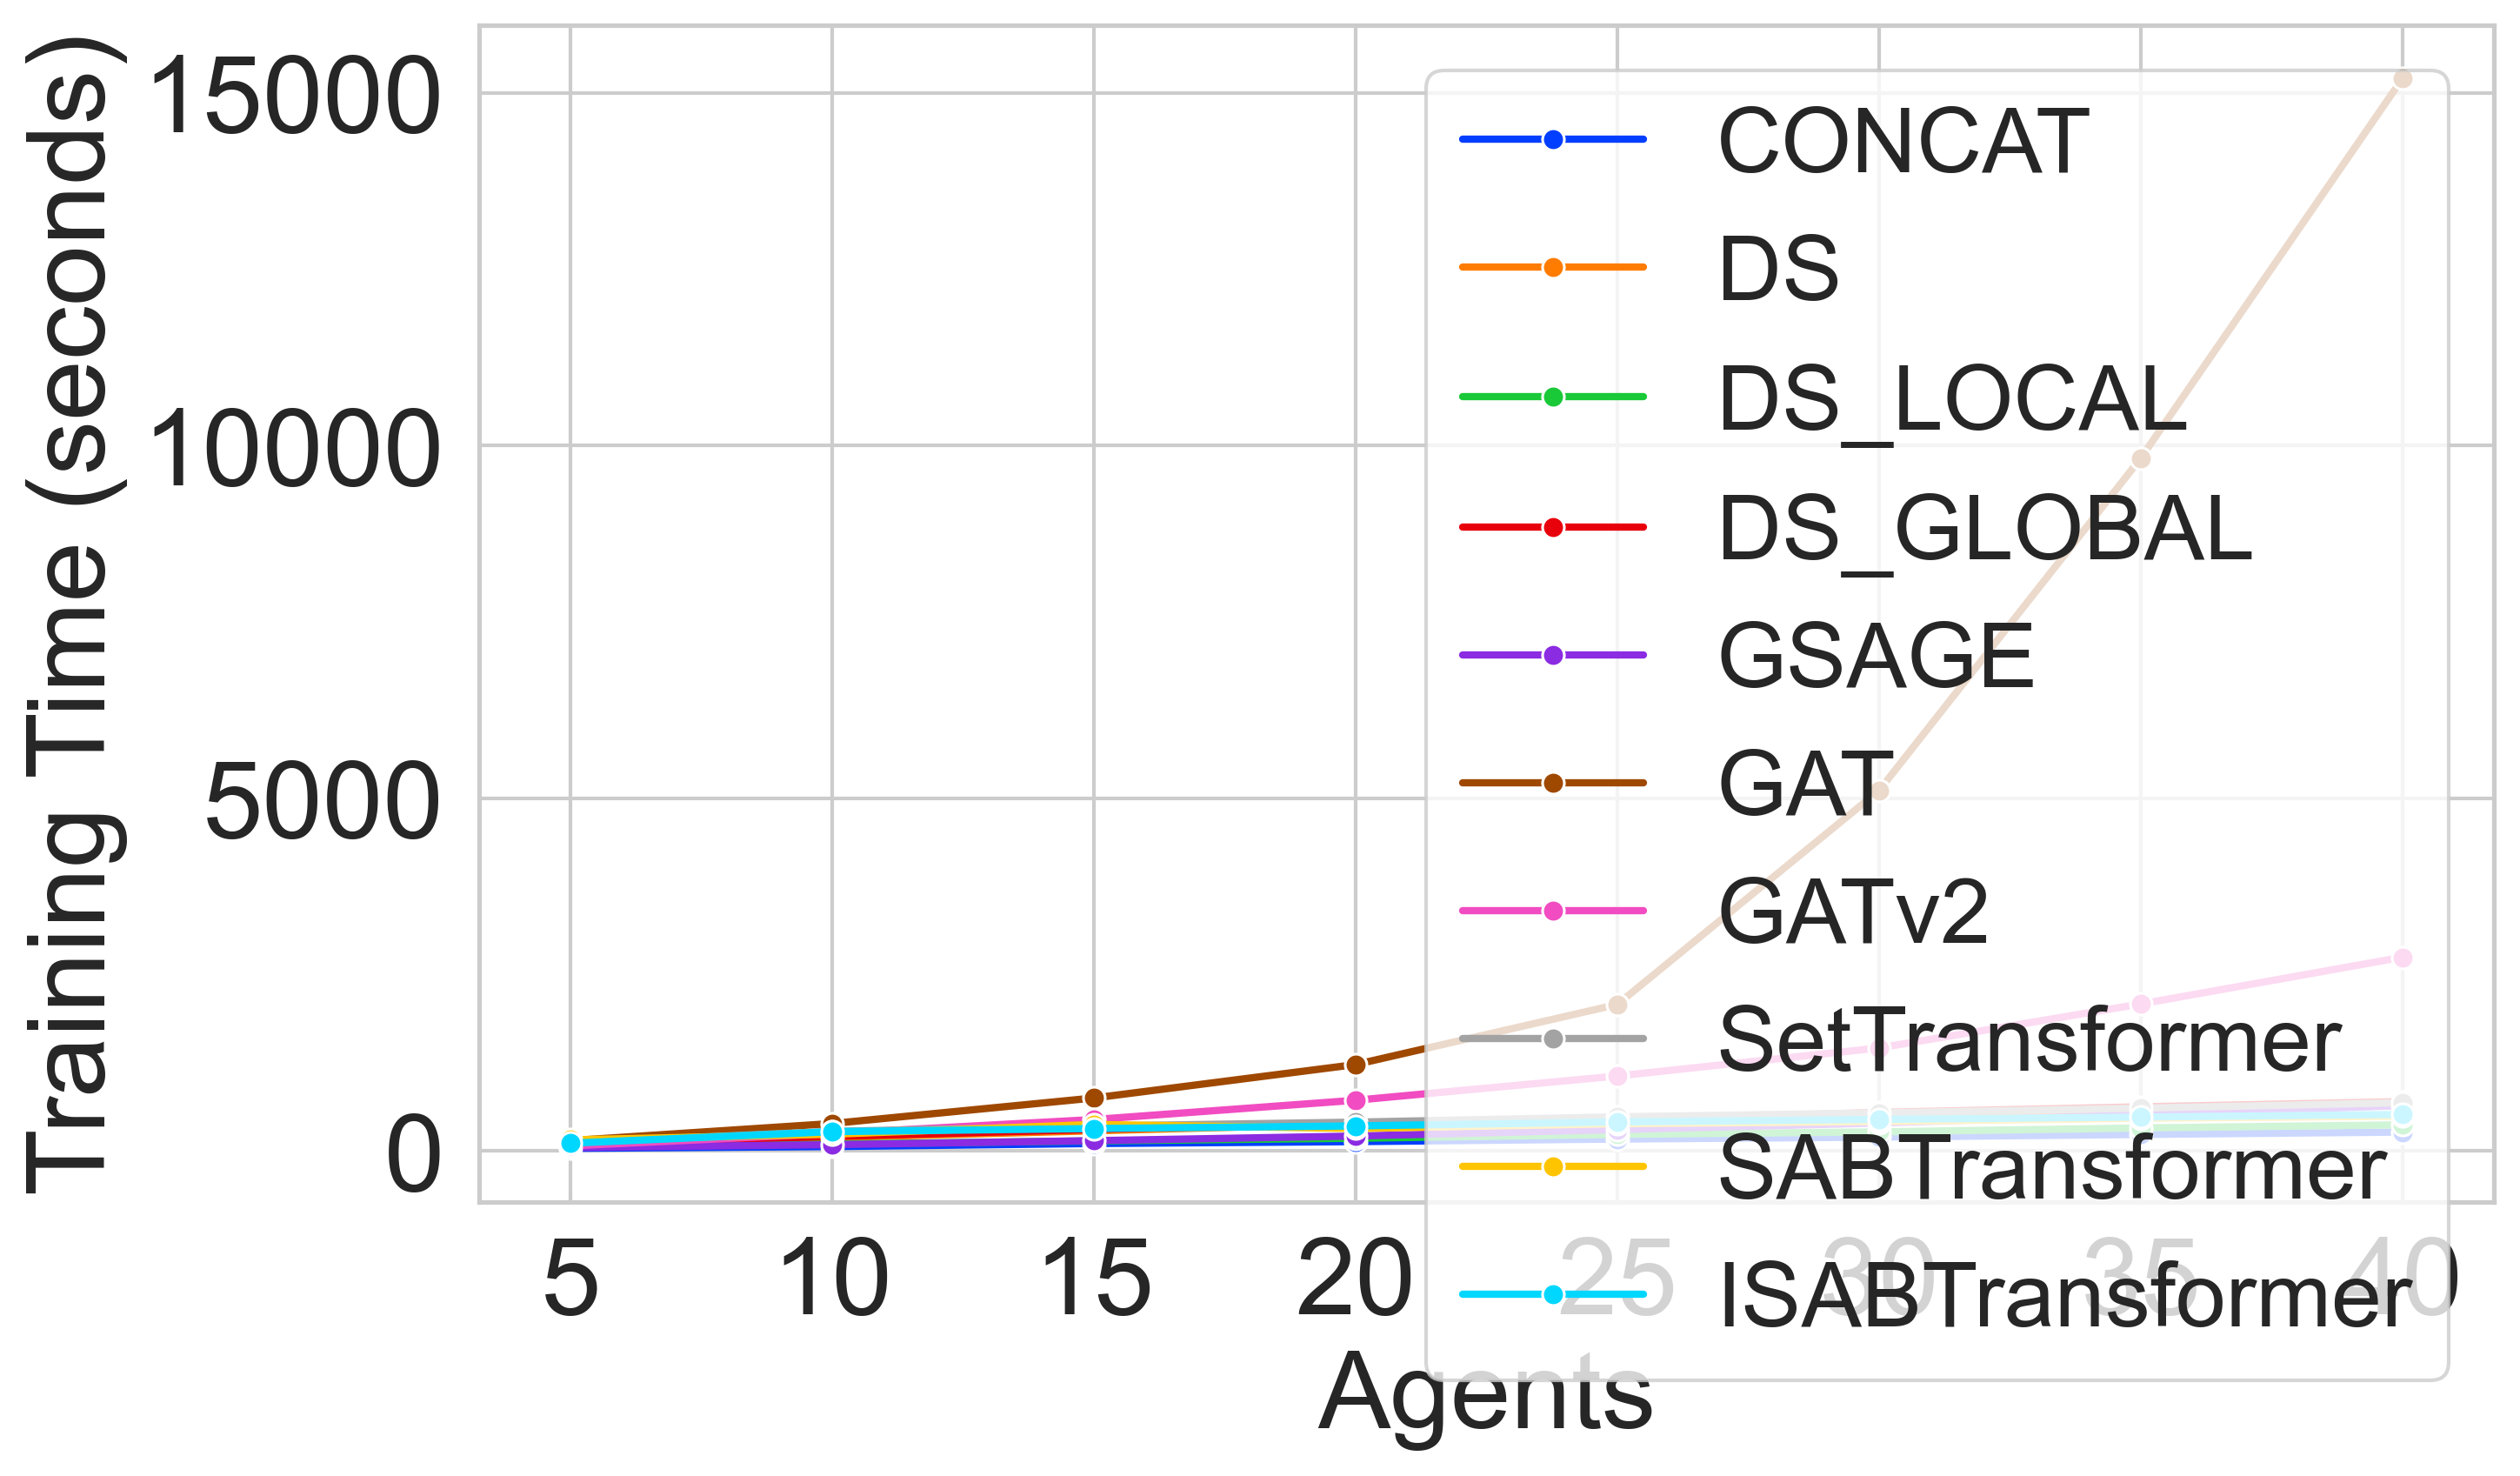

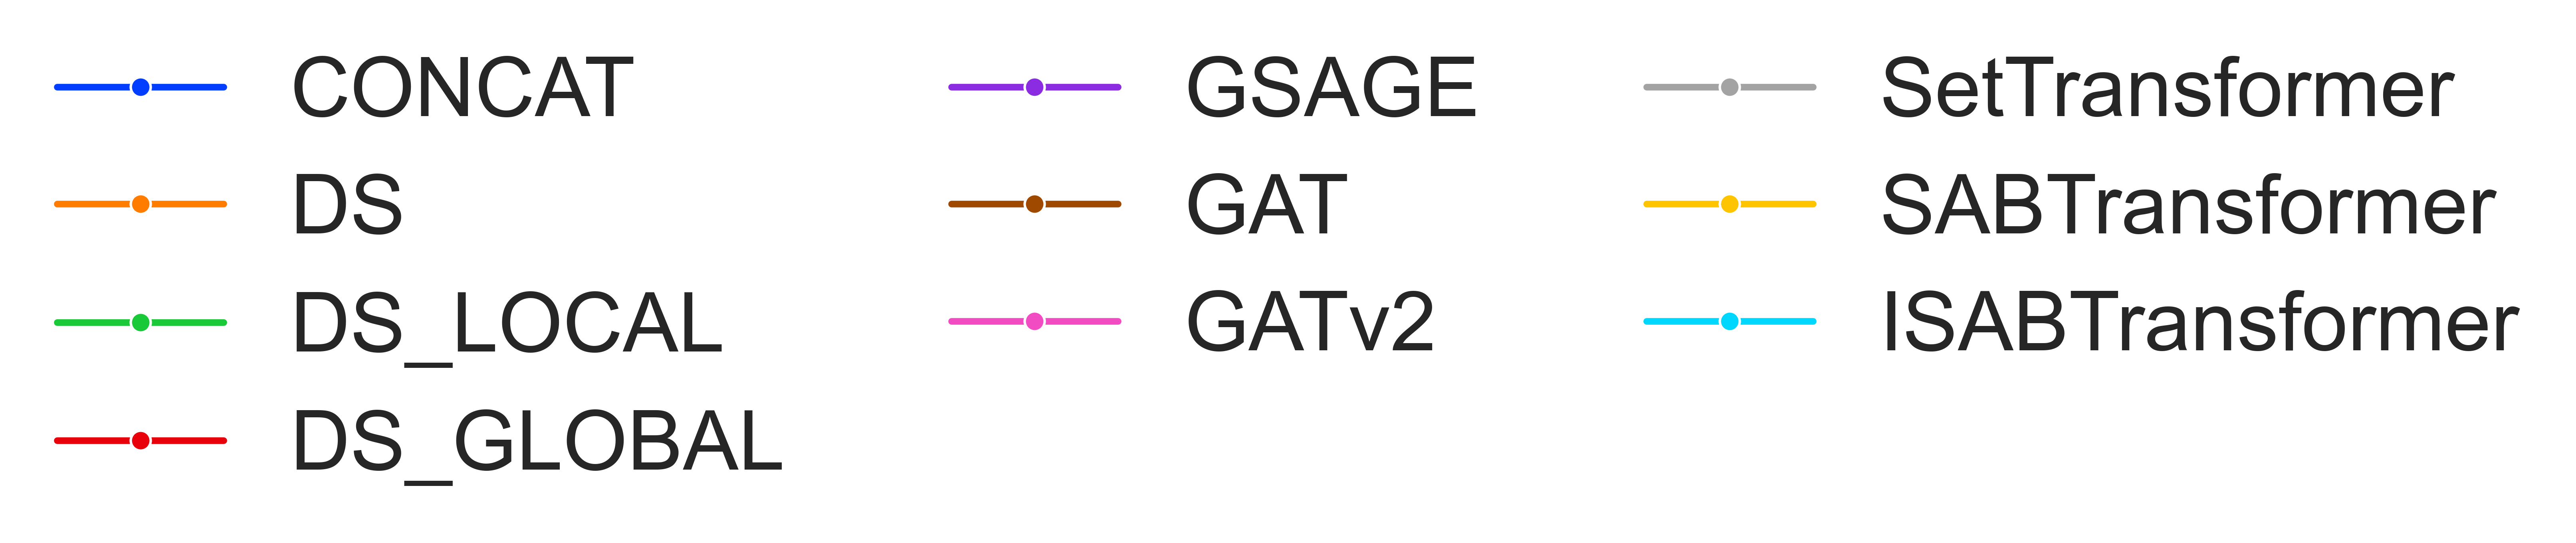

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------- Main plot (no legend) --------
fig, ax = plt.subplots(figsize=(10, 6))

# Get unique strategies
strategies = df['strategy'].unique()

# Plot each strategy
for strategy in strategies:
    subset = df[df['strategy'] == strategy]
    sns.lineplot(
        data=subset,
        x='agents',
        y='training_time',
        label=strategy,
        marker='o',
        linewidth=2,
        linestyle='-',
        estimator='mean',
        ax=ax,
    )

custom_ticks = df['agents'].unique()
ax.set_xticks(custom_ticks)
ax.set_xlabel('Agents')
ax.set_ylabel('Training Time (seconds)')
ax.grid(True)

# Get handles and labels, then remove legend from main plot
handles, labels = ax.get_legend_handles_labels()
plt.tight_layout()
plt.show()

# -------- Legend-only figure --------
fig_leg = plt.figure(figsize=(8, 2), dpi=600)
leg = fig_leg.legend(handles, labels, loc='center', ncol=3, frameon=False)
plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
from scipy.stats import linregress
# If R-squared is close to 1, it's a good fit for N^k
# The slope is k of power-law relationship (Y = aX^k)

def get_slope_rsquared(agents, data_points):
    # performing linear regression on log-transformed data
    agents = np.array(agents)
    data_points = np.array(data_points)

    valid_indices = data_points > 0
    filtered_agents = agents[valid_indices]
    filtered_data_points = data_points[valid_indices]

    # Need at least two valid data points to perform linear regression
    if len(filtered_agents) < 2:
        return np.nan, np.nan, np.nan, np.nan # Cannot perform regression with less than 2 points

    log_agents = np.log10(filtered_agents)
    log_data_points = np.log10(filtered_data_points)

    slope, intercept, r_value, p_value, std_err = linregress(log_agents, log_data_points)

    return slope, r_value**2, log_agents, log_data_points

R2_THRESHOLD = 0.98

def get_complexity_class(data_points_full, log_agents, log_data_points):
    complexity = ""
    # Check for O(1) first (all zeros or constant)
    if all(dp == 0.0 for dp in data_points_full) or (len(set(data_points_full)) == 1 and data_points_full[0] != 0.0):
        complexity = "$O(1)$"
    elif np.isnan(r2): # Less than 2 valid (non-zero) points for log-log regression
        complexity = "Insufficient Data"
    elif r2 >= R2_THRESHOLD:
        complexity = f"$O(N^{{{slope:.2f}}})$"
    else: # R-squared is low, likely a curve
        # Store the current slope for reference in o/omega notation
        reference_k = slope if not np.isnan(slope) else 1.0 # Default to 1 if slope is nan here for some reason

        if len(log_agents) >= 4:
            # Heuristic for curve direction: compare slope of first two vs last two valid points
            try:
                slope_start, _, _, _, _ = linregress(log_agents[:2], log_data_points[:2])
                slope_end, _, _, _, _ = linregress(log_agents[-2:], log_data_points[-2:])

                if slope_end > slope_start + 1e-6: # Add tolerance for floating point comparisons
                    complexity = f"$omega(N^{{{reference_k:.2f}}})$ (Upward Curve)"
                elif slope_end < slope_start - 1e-6:
                    complexity = f"$o(N^{{{reference_k:.2f}}})$ (Downward Curve)"
                else:
                    complexity = f"Curved (Complex)" # Very subtle curve or near linear but low R2
            except ValueError: # Not enough unique points for sub-slopes (e.g., all same value after log)
                complexity = f"Curved (No Direction Heuristic)"
        else:
            complexity = f"Curved (No Direction Heuristic)"
    return complexity

In [14]:
results = []

# Get unique strategies
strategies = df['strategy'].unique()

# Metrics you want to analyze for scaling
metrics_to_analyze = ['training_memory_usage', 'training_time', 'flops', 'parameters']

# Iterate through each strategy and each metric to calculate slope and R-squared
for strategy in strategies:
    strategy_df = df[df['strategy'] == strategy]
    agents_data = pd.to_numeric(strategy_df['agents'].tolist()) # Independent variable (X)

    for metric_col in metrics_to_analyze:
        data_points = strategy_df[metric_col].tolist() # Dependent variable (Y)

        slope, r2, log_agents, log_data_points = get_slope_rsquared(agents_data, data_points)
        complexity = get_complexity_class(data_points, log_agents, log_data_points)
        results.append({
            'Strategy': strategy,
            'Metric': metric_col,
            'Slope (k)': slope,
            'R-squared': r2,
            'Complexity Class': complexity

        })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Optional: Format for better readability
results_df['Slope (k)'] = results_df['Slope (k)'].round(3)
results_df['R-squared'] = results_df['R-squared'].round(3)


In [15]:
df_sorted = results_df.sort_values(by=['Metric', 'Strategy'])

In [16]:
print(df_sorted)

           Strategy                 Metric  Slope (k)  R-squared  \
2            CONCAT                  flops      1.763      0.999   
6                DS                  flops      1.001      1.000   
14        DS_GLOBAL                  flops      1.000      1.000   
10         DS_LOCAL                  flops      1.000      1.000   
22              GAT                  flops      1.000      1.000   
26            GATv2                  flops      1.000      1.000   
18            GSAGE                  flops      1.000      1.000   
38  ISABTransformer                  flops      0.905      0.999   
34   SABTransformer                  flops      1.145      0.999   
30   SetTransformer                  flops      0.951      1.000   
3            CONCAT             parameters      0.763      0.995   
7                DS             parameters      0.000      0.000   
15        DS_GLOBAL             parameters      0.000      0.000   
11         DS_LOCAL             parameters      